In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
full_df = pd.read_csv('iPSCPlate06_final.csv')
genes = pd.read_excel('Plate06Genes.xlsx', sheet_name='vertical')
grnas = pd.read_excel('Plate06gRNAs.xlsx', sheet_name='vertical')

In [3]:
# Just getting the values I'd like to work with
full_df = full_df[['AreaOccupied_AreaOccupied_labels',
                 'AreaOccupied_TotalArea_labels',
                 'Count_labels',
                 'Metadata_Day',
                 'Metadata_Field',
                 'Metadata_Plate',
                 'Metadata_Well']]

# Renaming the columns for ease
full_df.rename(columns={'AreaOccupied_AreaOccupied_labels': 'AreaOccupied',
                       'AreaOccupied_TotalArea_labels': 'TotalArea',
                       'Count_labels': 'Count',
                       'Metadata_Day': 'Day',
                       'Metadata_Field': 'Field',
                       'Metadata_Plate': 'Plate',
                       'Metadata_Well': 'Well'}, inplace=True)

# Renaming columns in the genes and grna df's so the 2 merges doesn't overwrite the 'Sample' column
genes.rename(columns={'Well': 'Well', 'Sample': 'Gene'}, inplace=True)
grnas.rename(columns={'Well': 'Well', 'Sample': 'grna'}, inplace=True)

# Merging on the Gene and grna columns
full_df = full_df.merge(genes, how='left', on='Well')
full_df = full_df.merge(grnas, how='left', on='Well')
full_df.head()

,AreaOccupied,TotalArea,Count,Day,Field,Plate,Well,Gene,grna
0,8836.0,4161600.0,35.0,0,1,6,B02,NT,g2
1,19616.0,4161600.0,60.0,1,1,6,B02,NT,g2
2,47122.0,4161600.0,164.0,2,1,6,B02,NT,g2
3,129811.0,4161600.0,491.0,3,1,6,B02,NT,g2
4,378819.0,4161600.0,1563.0,4,1,6,B02,NT,g2


In [4]:
# Summing all the fields per well per day
full_df_summed = full_df.groupby(['Well', 'Day']).agg({'AreaOccupied': 'sum',
                                                       'TotalArea': 'sum',
                                                       'Count': 'sum',
                                                       'Gene': 'first',
                                                       'grna': 'first'})

In [5]:
# Making a table how many cells were in each well per day
pivot_table = pd.pivot_table(data=full_df_summed, values = 'Count', index='Well', columns='Day')
pivot_table.head()

Day,0,1,2,3,4
Well,,,,,
B02,636.0,1087.0,3266.0,8835.0,29436.0
B03,657.0,1348.0,3977.0,12782.0,38901.0
B04,749.0,1214.0,4249.0,14092.0,39505.0
B05,615.0,832.0,2596.0,8255.0,29500.0
B06,574.0,1200.0,3302.0,8511.0,17564.0


In [6]:
# For this plate I messed up wells B09 and B10, so need to remove those:
pivot_table.shape

(60, 5)

In [7]:
pivot_table.drop(index=['B09', 'B10'], inplace=True)
pivot_table.shape

(58, 5)

In [8]:
# Getting the fold change from Day 0 for each Day for each well (just the value divided by the day 0 value)
pivot_table_fc = pivot_table.div(pivot_table.iloc[:,0], axis=0)
pivot_table_fc.head()

Day,0,1,2,3,4
Well,,,,,
B02,1.0,1.709119,5.135220,13.891509,46.283019
B03,1.0,2.051750,6.053272,19.455099,59.210046
B04,1.0,1.620828,5.672897,18.814419,52.743658
B05,1.0,1.352846,4.221138,13.422764,47.967480
B06,1.0,2.090592,5.752613,14.827526,30.599303


In [9]:
# Merging back on the gene and grna info
pivot_table_fc.reset_index(inplace=True)
pivot_all = pivot_table_fc.merge(genes, how='left', on='Well')
pivot_all = pivot_all.merge(grnas, how='left', on='Well')
pivot_all.head()

,Well,0,1,2,3,4,Gene,grna
0,B02,1.0,1.709119,5.135220,13.891509,46.283019,NT,g2
1,B03,1.0,2.051750,6.053272,19.455099,59.210046,NT,g2
2,B04,1.0,1.620828,5.672897,18.814419,52.743658,NT,g2
3,B05,1.0,1.352846,4.221138,13.422764,47.967480,NT,g2
4,B06,1.0,2.090592,5.752613,14.827526,30.599303,GTF2i,g1


In [10]:
# Now taking the average of the 4 wells per guide/grna
avg_fc = pivot_all.groupby(['Gene', 'grna']).agg('mean')
avg_fc.reset_index(inplace=True)

# making a 'fullname' column for ease for later, and making it the index
avg_fc['FullName'] = avg_fc['Gene'] + '_' + avg_fc['grna']
avg_fc.set_index('FullName', inplace=True)
avg_fc.drop(columns=['Gene', 'grna'], inplace=True)
avg_fc

,0,1,2,3,4
FullName,,,,,
CHD8_g1,1.0,1.882163,6.206211,19.794624,60.724445
CHD8_g2,1.0,1.703529,4.971878,16.096630,51.741678
CHD8_g3,1.0,1.590455,4.556047,14.387974,43.521293
GTF2i_g1,1.0,1.901462,5.988094,16.326645,35.638849
GTF2i_g2,1.0,1.713082,4.642399,12.659059,36.233894
GTF2i_g3,1.0,1.587407,4.856774,16.246240,54.459672
MECP2_g1,1.0,2.097946,6.588202,20.903424,60.076155
MECP2_g2,1.0,2.032908,6.499264,18.750957,55.030894
MECP2_g3,1.0,2.047903,6.533560,19.562664,58.222403


In [11]:
# Converting the calculating the percent difference between the NT control and each gene/grna
avg_fc_pct0 = avg_fc.sub(avg_fc.iloc[9,:], axis=1)
avg_fc_pct1 = avg_fc_pct0.div(avg_fc.iloc[9,:], axis=1)
avg_fc_pct = avg_fc_pct1 * 100
avg_fc_pct.head()

,0,1,2,3,4
FullName,,,,,
CHD8_g1,0.0,11.791598,17.750792,20.728756,17.794777
CHD8_g2,0.0,1.181547,-5.668275,-1.825562,0.369785
CHD8_g3,0.0,-5.534491,-13.557863,-12.246767,-15.576322
GTF2i_g1,0.0,12.937853,13.612455,-0.422682,-30.866882
GTF2i_g2,0.0,1.748943,-11.919497,-22.791539,-29.712598


In [12]:
# Rearranging the rows to put NT at the top
avg_fc_pct2 = avg_fc_pct.reindex(index=['NT_g2', 'CHD8_g1', 'CHD8_g2', 'CHD8_g3', 'GTF2i_g1', 'GTF2i_g2', 'GTF2i_g3',
                                        'MECP2_g1', 'MECP2_g2', 'MECP2_g3', 'STAG1_g1', 'STAG1_g2',
                                        'STAG2_g1', 'STAG2_g2', 'STAG2_g3'])

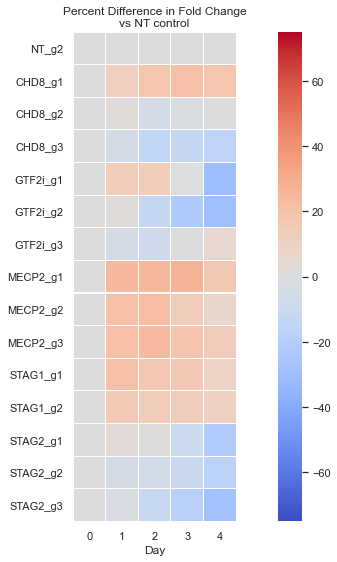

In [13]:
# And plotting it as a heatmap
fig, ax = plt.subplots(figsize=(15,9))
heatmap = sns.heatmap(avg_fc_pct2, vmin=-75, vmax=75, linewidths=0.1, center=0, cmap='coolwarm', square=True).set(ylabel=None, xlabel='Day', title='Percent Difference in Fold Change\nvs NT control')
plt.savefig('iPSCPlate03_heatmap.png', bbox_inches='tight')

In [14]:
# Want to plot STAG1, STAG2, and NT to see better. Need to 'unpivot' the dataframe to get it into long form
unpivot = pivot_all.melt(id_vars=['Well', 'Gene', 'grna'], value_vars=[0,1,2,3,4], value_name='FoldChange', 
                         var_name='Day')

In [17]:
# Subsetting just the genes of interest
subset = unpivot[unpivot['Gene'].isin(['NT', 'STAG1', 'STAG2'])]
subset['FullName'] = subset['Gene'] + '_' + subset['grna']
subset

<ipython-input-17-015901dcc87b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['FullName'] = subset['Gene'] + '_' + subset['grna']


,Well,Gene,grna,Day,FoldChange,FullName
0,B02,NT,g2,0,1.000000,NT_g2
1,B03,NT,g2,0,1.000000,NT_g2
2,B04,NT,g2,0,1.000000,NT_g2
3,B05,NT,g2,0,1.000000,NT_g2
7,B11,STAG2,g1,0,1.000000,STAG2_g1
...,...,...,...,...,...,...
281,G03,STAG1,g2,4,70.516556,STAG1_g2
282,G04,STAG1,g2,4,54.579750,STAG1_g2
283,G05,STAG1,g2,4,58.348093,STAG1_g2
288,G10,STAG2,g3,4,37.300855,STAG2_g3


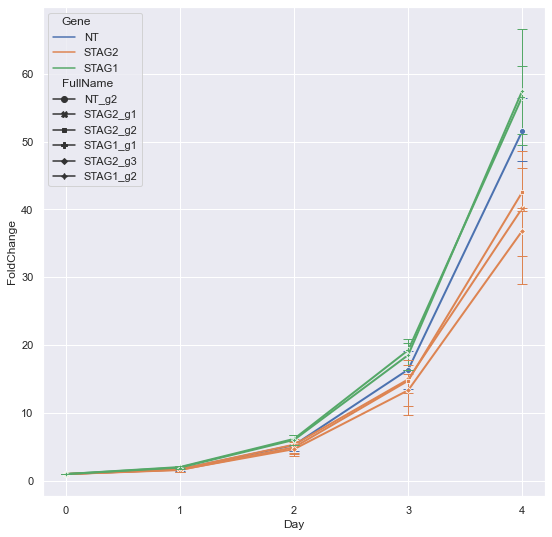

In [20]:
# Plotting and saving

fig, ax = plt.subplots(figsize=(9,9))
g = sns.lineplot(data=subset, x='Day', y='FoldChange', style='FullName', hue='Gene', markers=True, dashes=False, 
                 err_style='bars', err_kws={'capsize':5, 'elinewidth': 1, 'capthick': 1}, linewidth=2)
plt.xticks(ticks=[0,1,2,3,4], labels=[0,1,2,3,4])
plt.savefig('Plate06NTvsSTAGs.png', bbox_inches='tight')